# AIR POLLUTION PREDICTION USING MACHINE LEARNING


In [127]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [128]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [129]:
#T·∫£i th∆∞ vi·ªán statsmodels 
! pip install statsmodels



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [130]:
## Import libraries
import os
import pickle
from math import sqrt

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Regressor - only using as requested
import xgboost as xgb
## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


In [131]:
# File paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Data")
MODEL_PATH = os.path.join(BASE_DIR, "models")
RESULTS_PATH = os.path.join(BASE_DIR, "results")
CLEANED_DATASET_PATH = os.path.join(BASE_DIR, "cleaned_datasets")
DATASET_PATH = os.path.join(DATA_DIR, "DATASET_state_weather_aqi_data_PPNC.csv")

In [132]:
# Creating appropriate folders if not already existing
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

if not os.path.exists(CLEANED_DATASET_PATH):
    os.makedirs(CLEANED_DATASET_PATH)


In [133]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 18

In [134]:
# Import air quality data
aqi_data = pd.read_csv(DATASET_PATH)

# View data shape and basic information
print("Dataset shape:", aqi_data.shape, "\n")
print("Dataset information:\n")

Dataset shape: (1564, 18) 

Dataset information:



In [135]:
aqi_data.info()
print("\nColumn names:", list(aqi_data.columns), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   1564 non-null   object 
 1   district               1564 non-null   object 
 2   DateTime               1564 non-null   object 
 3   PM2.5                  1391 non-null   float64
 4   PM10                   1227 non-null   float64
 5   NO2                    1409 non-null   float64
 6   NH3                    1120 non-null   float64
 7   SO2                    1351 non-null   float64
 8   CO                     1501 non-null   float64
 9   OZONE                  1415 non-null   float64
 10  AQI                    1564 non-null   int64  
 11  TEMP                   1564 non-null   float64
 12  PRES                   1564 non-null   float64
 13  DEWP                   1564 non-null   float64
 14  RAIN                   1564 non-null   float64
 15  wd  

In [136]:
# View data description
print("Dataset statistics:\n")
print(aqi_data.describe())

Dataset statistics:

             PM2.5         PM10          NO2          NH3          SO2  \
count  1391.000000  1227.000000  1409.000000  1120.000000  1351.000000   
mean    182.887132   141.654442    46.735273     8.410714    16.469282   
std     106.309536    66.750720    31.698556     5.592273    12.578891   
min       9.000000    21.000000     1.000000     1.000000     1.000000   
25%      88.000000    93.000000    24.000000     4.000000     8.000000   
50%     164.000000   130.000000    42.000000     7.000000    13.000000   
75%     278.500000   184.500000    64.000000    12.000000    20.000000   
max     441.000000   394.000000   247.000000    34.000000    92.000000   

                CO        OZONE          AQI         TEMP         PRES  \
count  1501.000000  1415.000000  1564.000000  1564.000000  1564.000000   
mean     51.441706    29.792933   188.368286    29.086445  1007.708312   
std      28.032483    22.786605    98.940549     2.978614     2.582796   
min       1.0000

In [137]:
# Check for missing values
print("\nMissing values per column:\n")
print(aqi_data.isna().sum())


Missing values per column:

City                       0
district                   0
DateTime                   0
PM2.5                    173
PM10                     337
NO2                      155
NH3                      444
SO2                      213
CO                        63
OZONE                    149
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64


In [138]:
# Clean the dataset by removing null values
clean_aqi_data = aqi_data.dropna()

clean_aqi_data["DateTime"] = pd.to_datetime(clean_aqi_data["DateTime"], format="%m/%d/%Y %H:%M")
clean_aqi_data.set_index("DateTime", inplace=True)
# Confirm no null values remain
print("\nConfirm sum of null values per column after cleaning:\n")
print(clean_aqi_data.isna().sum())
print("\nClean dataset shape:", clean_aqi_data.shape, "\n")


Confirm sum of null values per column after cleaning:

City                     0
district                 0
PM2.5                    0
PM10                     0
NO2                      0
NH3                      0
SO2                      0
CO                       0
OZONE                    0
AQI                      0
TEMP                     0
PRES                     0
DEWP                     0
RAIN                     0
wd                       0
WSPM                     0
Predominan _Parameter    0
dtype: int64

Clean dataset shape: (966, 17) 



In [139]:
# Save the cleaned dataset
clean_aqi_data.to_csv(os.path.join(CLEANED_DATASET_PATH, 'clean_aqi_data.csv'), index=False)

In [140]:
# 1. View first and last few records
print("First 5 records:")
clean_aqi_data.head()

First 5 records:


City  district  PM2.5  PM10   NO2  NH3   SO2    CO  \
DateTime                                                                   
2024-11-01 01:00:00  TPHCM        Q1   68.0  64.0  17.0  4.0  28.0  31.0   
2024-11-01 02:00:00  TPHCM        Q3   67.0  70.0  23.0  2.0  13.0  49.0   
2024-11-01 04:00:00  TPHCM  T√¢n B√¨nh   93.0  93.0  31.0  3.0   9.0  57.0   
2024-11-01 05:00:00  TPHCM   T√¢n Ph√∫   60.0  55.0  20.0  5.0  18.0  29.0   
2024-11-01 06:00:00  TPHCM        Q1   48.0  52.0  25.0  3.0  12.0  43.0   

                     OZONE  AQI  TEMP    PRES  DEWP  RAIN     wd  WSPM  \
DateTime                                                                 
2024-11-01 01:00:00   40.0   68  30.0  1009.0  22.0   0.0  130.0  13.0   
2024-11-01 02:00:00   77.0   77  29.0  1009.0  23.1   0.0  149.0  12.8   
2024-11-01 04:00:00   61.0   93  29.0  1008.0  23.0   0.0  130.0  16.6   
2024-11-01 05:00:00   53.0   60  28.9  1008.1  23.2   0.0  140.0  16.4   
2024-11-01 06:00:00   67.0   67  29.0  1009.0  23.0   0.0  130.0  14.8   

                    Predominan _Parameter  
DateTime                                   
2024-11-01 01:00:00                 PM2.5  
2024-11-01 02:00:00                 OZONE  
2024-11-01 04:00:00                  PM10  
2024-11-01 05:00:00                 PM2.5  
2024-11-01 06:00:00                 OZONE

In [141]:
# 1. View records
print("\nLast 5 records:")
clean_aqi_data.tail()


Last 5 records:


City  district  PM2.5   PM10   NO2   NH3   SO2    CO  \
DateTime                                                                     
2025-01-05 00:00:00  TPHCM        Q6  247.0  167.0  67.0   5.0  12.0  43.0   
2025-01-05 01:00:00  TPHCM        Q9  163.0  142.0  57.0   7.0  10.0  39.0   
2025-01-05 02:00:00  TPHCM  B√¨nh T√¢n  279.0  215.0  78.0  11.0  23.0  31.0   
2025-01-05 03:00:00  TPHCM        Q1  162.0  136.0  43.0   4.0  16.0  34.0   
2025-01-05 04:00:00  TPHCM        Q4  213.0  152.0  55.0   5.0  11.0  95.0   

                     OZONE  AQI  TEMP    PRES  DEWP  RAIN     wd  WSPM  \
DateTime                                                                 
2025-01-05 00:00:00   55.0  247  23.1  1012.0  16.1   0.0   50.0   7.6   
2025-01-05 01:00:00    8.0  163  22.1  1012.0  16.1   0.0   20.0   5.4   
2025-01-05 02:00:00   53.0  279  26.1  1010.0  23.1   0.1  120.0  11.2   
2025-01-05 03:00:00   44.0  162  21.1  1011.0  17.1   0.0  340.0   5.4   
2025-01-05 04:00:00   64.0  213  22.1  1010.0  17.1   0.0  348.6   3.6   

                    Predominan _Parameter  
DateTime                                   
2025-01-05 00:00:00                 PM2.5  
2025-01-05 01:00:00                 PM2.5  
2025-01-05 02:00:00                 PM2.5  
2025-01-05 03:00:00                 PM2.5  
2025-01-05 04:00:00                 PM2.5

In [142]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'] 

In [143]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)

In [144]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [145]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with NH3'):
    # T·∫°o mask m·ªõi ch·ªâ che ph·∫ßn tr√πng l·∫∑p ph√≠a tr√™n ƒë∆∞·ªùng ch√©o
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # k=1 ƒë·ªÉ gi·ªØ l·∫°i ƒë∆∞·ªùng ch√©o ch√≠nh
    
    # Thi·∫øt l·∫≠p figure v·ªõi k√≠ch th∆∞·ªõc ph√π h·ª£p
    plt.figure(figsize=(12, 10))
    
    # V·∫Ω heatmap v·ªõi c√°c th√¥ng s·ªë ƒë∆∞·ª£c t·ªëi ∆∞u
    sns.heatmap(
        corr, 
        mask=mask,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5,
        annot_kws={"size": 10}
    )
    
    # ƒêi·ªÅu ch·ªânh ti√™u ƒë·ªÅ v√† nh√£n
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # ƒê·∫£m b·∫£o layout ph√π h·ª£p
    plt.tight_layout()
    
    
def visualize_series_single(series_data=None, days=None, title='NH3 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='NH3')
    # return np.array(data), predictions
    return predictions

# Data Segmentation

In [146]:
y_pm25 = clean_aqi_data['PM2.5']

In [147]:
features_X = clean_aqi_data[clean_aqi_data.columns[2:16]]
y_nh3 = clean_aqi_data['NH3']
y_pm10 = clean_aqi_data.PM10
y_so2 = clean_aqi_data.SO2
y_no2 = clean_aqi_data.NO2
y_co = clean_aqi_data.CO
y_so2 = clean_aqi_data.SO2
y_pm25 = clean_aqi_data['PM2.5']

In [148]:
features_X.head(3)

PM2.5  PM10   NO2  NH3   SO2    CO  OZONE  AQI  TEMP  \
DateTime                                                                    
2024-11-01 01:00:00   68.0  64.0  17.0  4.0  28.0  31.0   40.0   68  30.0   
2024-11-01 02:00:00   67.0  70.0  23.0  2.0  13.0  49.0   77.0   77  29.0   
2024-11-01 04:00:00   93.0  93.0  31.0  3.0   9.0  57.0   61.0   93  29.0   

                       PRES  DEWP  RAIN     wd  WSPM  
DateTime                                              
2024-11-01 01:00:00  1009.0  22.0   0.0  130.0  13.0  
2024-11-01 02:00:00  1009.0  23.1   0.0  149.0  12.8  
2024-11-01 04:00:00  1008.0  23.0   0.0  130.0  16.6

In [149]:
y_pm25.head(3)

DateTime
2024-11-01 01:00:00    68.0
2024-11-01 02:00:00    67.0
2024-11-01 04:00:00    93.0
Name: PM2.5, dtype: float64

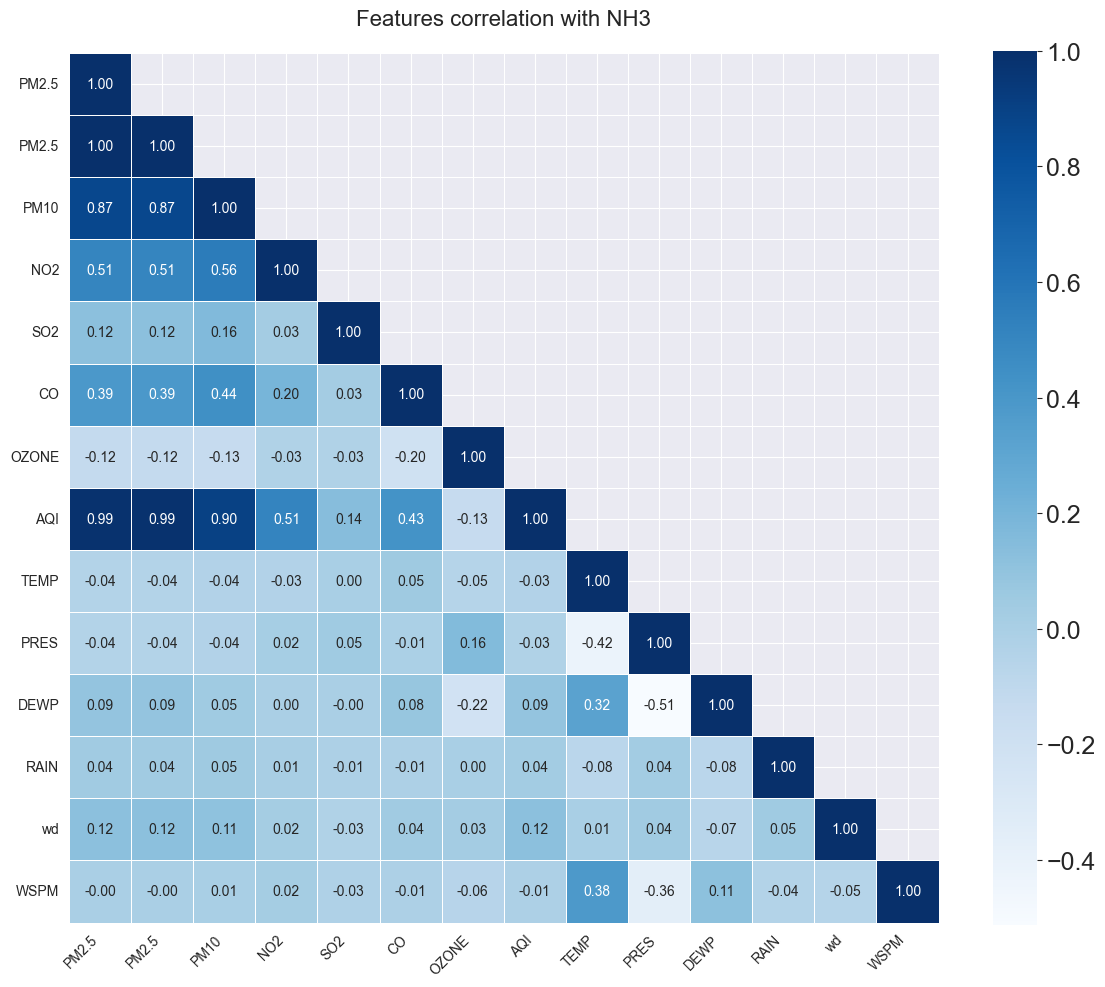

In [150]:
if 'NH3' in features_X.columns:
    features_for_corr = features_X.copy()
    # Lo·∫°i b·ªè NH3 kh·ªèi features_X
    features_for_corr = features_for_corr.drop(columns=['NH3'])
    # Th√™m l·∫°i NH3 v√†o ƒë·∫ßu
    corr = pd.concat([y_pm25, features_for_corr], axis='columns').corr()
else:
    corr = pd.concat([y_pm25, features_X], axis='columns').corr()

plot_corr(corr, title='Features correlation with NH3')

M·ªëi t∆∞∆°ng quan v·ªõi c√°c ch·∫•t √¥ nhi·ªÖm kh√°c:
NH‚ÇÉ c√≥ t∆∞∆°ng quan trung b√¨nh v·ªõi CO (h·ªá s·ªë t∆∞∆°ng quan = 0.48), cho th·∫•y c√≥ kh·∫£ nƒÉng hai ch·∫•t n√†y c√πng xu·∫•t hi·ªán t·ª´ c√°c ngu·ªìn ph√°t th·∫£i gi·ªëng nhau, nh∆∞ giao th√¥ng, ƒë·ªët nhi√™n li·ªáu ho·∫∑c ho·∫°t ƒë·ªông n√¥ng nghi·ªáp.

NH‚ÇÉ c√≥ t∆∞∆°ng quan nh·∫π v·ªõi:

PM2.5 (0.28)

PM10 (0.26)

NO‚ÇÇ (0.20)

ƒêi·ªÅu n√†y ph·∫£n √°nh r·∫±ng khi n·ªìng ƒë·ªô b·ª•i m·ªãn ho·∫∑c NO‚ÇÇ tƒÉng, th√¨ NH‚ÇÉ c≈©ng c√≥ xu h∆∞·ªõng tƒÉng, d√π m·ªëi li√™n h·ªá kh√¥ng m·∫°nh. ƒê√¢y c√≥ th·ªÉ l√† h·ªá qu·∫£ t·ª´ ƒëi·ªÅu ki·ªán ƒë√¥ th·ªã h√≥a ho·∫∑c c√¥ng nghi·ªáp h√≥a.

NH‚ÇÉ c√≥ t∆∞∆°ng quan r·∫•t y·∫øu v·ªõi SO‚ÇÇ (0.05) v√† O‚ÇÉ (-0.03), ƒëi·ªÅu n√†y cho th·∫•y gi·ªØa NH‚ÇÉ v√† c√°c ch·∫•t kh√≠ n√†y kh√¥ng c√≥ m·ªëi quan h·ªá tuy·∫øn t√≠nh r√µ r·ªát trong d·ªØ li·ªáu.

üîπ M·ªëi t∆∞∆°ng quan v·ªõi c√°c y·∫øu t·ªë kh√≠ t∆∞·ª£ng:
Nhi·ªát ƒë·ªô (TEMP) c√≥ t∆∞∆°ng quan r·∫•t y·∫øu v·ªõi NH‚ÇÉ (0.11), cho th·∫•y nhi·ªát ƒë·ªô kh√¥ng ·∫£nh h∆∞·ªüng r√µ r·ªát ƒë·∫øn n·ªìng ƒë·ªô NH‚ÇÉ.

C√°c y·∫øu t·ªë kh√≠ t∆∞·ª£ng kh√°c c√≥ t∆∞∆°ng quan r·∫•t th·∫•p ho·∫∑c g·∫ßn b·∫±ng 0:

ƒêi·ªÉm s∆∞∆°ng (DEWP): 0.09

√Åp su·∫•t kh√≠ quy·ªÉn (PRES): -0.04

T·ªëc ƒë·ªô gi√≥ (WSPM): -0.06

L∆∞·ª£ng m∆∞a (RAIN): -0.01

Nh·ªØng gi√° tr·ªã n√†y cho th·∫•y c√°c y·∫øu t·ªë kh√≠ t∆∞·ª£ng kh√¥ng ƒë√≥ng vai tr√≤ l·ªõn trong vi·ªác thay ƒë·ªïi n·ªìng ƒë·ªô NH‚ÇÉ, d√π t·ªëc ƒë·ªô gi√≥ c√≥ th·ªÉ c√≥ xu h∆∞·ªõng l√†m lo√£ng NH‚ÇÉ nh·∫π.

<Axes: title={'center': 'NH3eries [TPHCM]'}, xlabel='DateTime'>

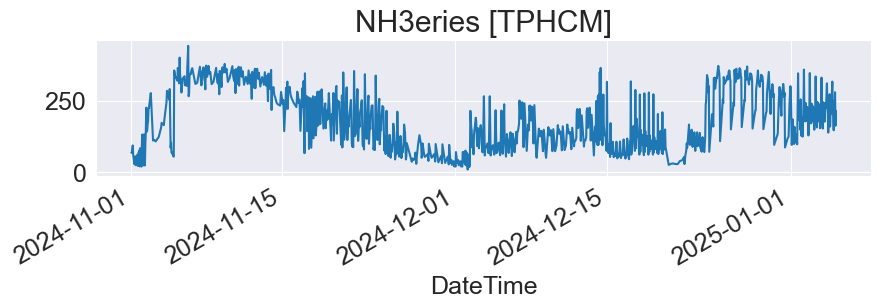

In [151]:
plt.figure(figsize=(10,2))
y_pm25.plot(title='NH3eries [TPHCM]')

 Xu h∆∞·ªõng t·ªïng th·ªÉ:
N·ªìng ƒë·ªô NH‚ÇÉ dao ƒë·ªông nh·∫π trong giai ƒëo·∫°n ƒë·∫ßu (tr∆∞·ªõc th√°ng 11), ch·ªß y·∫øu n·∫±m ·ªü m·ª©c th·∫•p ƒë·∫øn trung b√¨nh.

T·ª´ gi·ªØa ƒë·∫øn cu·ªëi th√°ng 11/2024, xu·∫•t hi·ªán nhi·ªÅu ƒë·ª£t tƒÉng ng·∫Øn h·∫°n r√µ r·ªát, v·ªõi gi√° tr·ªã cao nh·∫•t l√™n ƒë·∫øn tr√™n 70 ¬µg/m¬≥. ƒê√¢y l√† m·ª©c t∆∞∆°ng ƒë·ªëi cao so v·ªõi n·ªÅn chung.

Sau giai ƒëo·∫°n n√†y, n·ªìng ƒë·ªô NH‚ÇÉ ti·∫øp t·ª•c dao ƒë·ªông, tuy nhi√™n m·ª©c ƒë·ªô bi·∫øn ƒë·ªông gi·∫£m nh·∫π v√† kh√¥ng c√≤n c√°c ƒë·ªânh qu√° cao nh∆∞ tr∆∞·ªõc.

üîπ T√≠nh chu k·ª≥:
B·∫Øt ƒë·∫ßu t·ª´ gi·ªØa th√°ng 11, c√≥ s·ª± xu·∫•t hi·ªán c·ªßa c√°c dao ƒë·ªông d·∫°ng chu k·ª≥ theo ng√†y ‚Äì bi·ªÉu hi·ªán b·∫±ng c√°c s√≥ng l√™n xu·ªëng ƒë·ªÅu ƒë·∫∑n.

ƒêi·ªÅu n√†y cho th·∫•y ho·∫°t ƒë·ªông ph√°t th·∫£i NH‚ÇÉ mang t√≠nh l·∫∑p l·∫°i theo th·ªùi gian, nhi·ªÅu kh·∫£ nƒÉng li√™n quan ƒë·∫øn:

Ho·∫°t ƒë·ªông c√¥ng nghi·ªáp c√≥ l·ªãch tr√¨nh ·ªïn ƒë·ªãnh theo ca.

Giao th√¥ng ƒë√¥ th·ªã ho·∫∑c sinh ho·∫°t d√¢n c∆∞ c√≥ ƒë·∫∑c tr∆∞ng ng√†y ‚Äì ƒë√™m r√µ r√†ng.

Ph√°t th·∫£i t·ª´ n√¥ng nghi·ªáp (nh∆∞ x·ªãt thu·ªëc, b√≥n ph√¢n) c√≥ gi·ªù gi·∫•c c·ªë ƒë·ªãnh.

üîπ Hi·ªán t∆∞·ª£ng b·∫•t th∆∞·ªùng:
Kh√¥ng c√≥ ƒë·ªânh NH‚ÇÉ n√†o v∆∞·ª£t ng∆∞·ª°ng c·ª±c ƒëoan ho·∫∑c k√©o d√†i nhi·ªÅu ng√†y, kh√¥ng xu·∫•t hi·ªán hi·ªán t∆∞·ª£ng b·∫•t th∆∞·ªùng r√µ r·ªát nh∆∞ SO‚ÇÇ.

Tuy nhi√™n, m·ªôt v√†i ƒë·ªânh NH‚ÇÉ ƒë·ªôt ng·ªôt xu·∫•t hi·ªán v√† k√©o d√†i kho·∫£ng 1‚Äì2 ng√†y, c√≥ th·ªÉ li√™n quan ƒë·∫øn:

Ho·∫°t ƒë·ªông s·∫£n xu·∫•t n√¥ng nghi·ªáp quy m√¥ l·ªõn.

Th·ªùi ƒëi·ªÉm r√≤ r·ªâ ng·∫Øn h·∫°n t·ª´ h·ªá th·ªëng x·ª≠ l√Ω n∆∞·ªõc th·∫£i ho·∫∑c ch·∫•t th·∫£i h·ªØu c∆°.

üîπ T√≠nh ·ªïn ƒë·ªãnh v√† nhi·ªÖu:
Nh√¨n chung, bi·ªÉu ƒë·ªì NH‚ÇÉ kh√° ·ªïn ƒë·ªãnh v·ªÅ d√†i h·∫°n, kh√¥ng c√≥ xu h∆∞·ªõng tƒÉng hay gi·∫£m r√µ r·ªát.

C√≥ m·ªôt s·ªë ƒëo·∫°n d·ªØ li·ªáu nhi·ªÖu nh·∫π ho·∫∑c thi·∫øu ‚Äì bi·ªÉu hi·ªán b·∫±ng kho·∫£ng tr·ªëng ho·∫∑c ƒëi·ªÉm nh·∫£y b·∫•t th∆∞·ªùng, kh·∫£ nƒÉng do:

C·∫£m bi·∫øn m·∫•t t√≠n hi·ªáu t·∫°m th·ªùi.

Th·ªùi ti·∫øt nh∆∞ m∆∞a l·ªõn, gi√≥ m·∫°nh l√†m lo√£ng ho·∫∑c l√†m sai l·ªách ph√©p ƒëo.



<Axes: title={'center': 'NH3eries (last 2 months) [TPHCM]'}, xlabel='DateTime'>

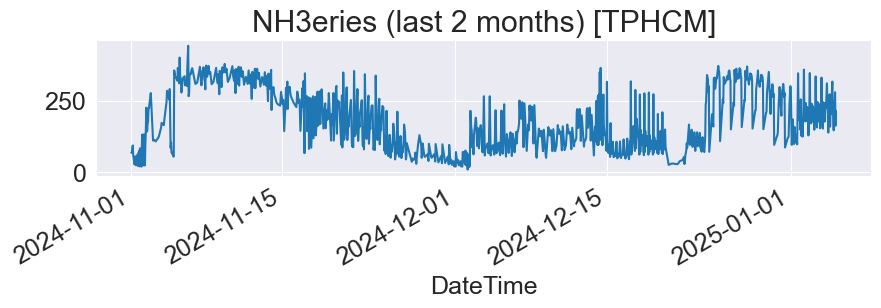

In [152]:
# Last 6 months (To understand pattern)
plt.figure(figsize=(10,2))
y_pm25.iloc[-24*31*2:].plot(title='NH3eries (last 2 months) [TPHCM]')

M·∫∑c d√π NH‚ÇÉ ph·∫ßn l·ªõn th·ªùi gian kh√¥ng v∆∞·ª£t ng∆∞·ª°ng nguy hi·ªÉm, s·ª± dao ƒë·ªông theo chu k·ª≥ ng√†y v√† nh·ªØng ƒë·ªânh c·ª•c b·ªô cho th·∫•y √¥ nhi·ªÖm NH‚ÇÉ t·∫°i TP.HCM v·∫´n t·ªìn t·∫°i r·ªßi ro m√¥i tr∆∞·ªùng.

ƒê·∫∑c bi·ªát, NH‚ÇÉ l√† kh√≠ ƒë·ªôc c√≥ th·ªÉ ·∫£nh h∆∞·ªüng ƒë·∫øn h√¥ h·∫•p v√† m·∫Øt, nh·∫•t l√† v·ªõi ng∆∞·ªùi l√†m vi·ªác ngo√†i tr·ªùi ho·∫∑c g·∫ßn ngu·ªìn ph√°t th·∫£i.

C·∫ßn k·∫øt h·ª£p th√™m d·ªØ li·ªáu v·ªÅ ngu·ªìn ph√°t th·∫£i, gi√≥ v√† ƒë·ªô ·∫©m ƒë·ªÉ x√¢y d·ª±ng m√¥ h√¨nh d·ª± b√°o ho·∫∑c c·∫£nh b√°o trong th·ªùi gian cao ƒëi·ªÉm.

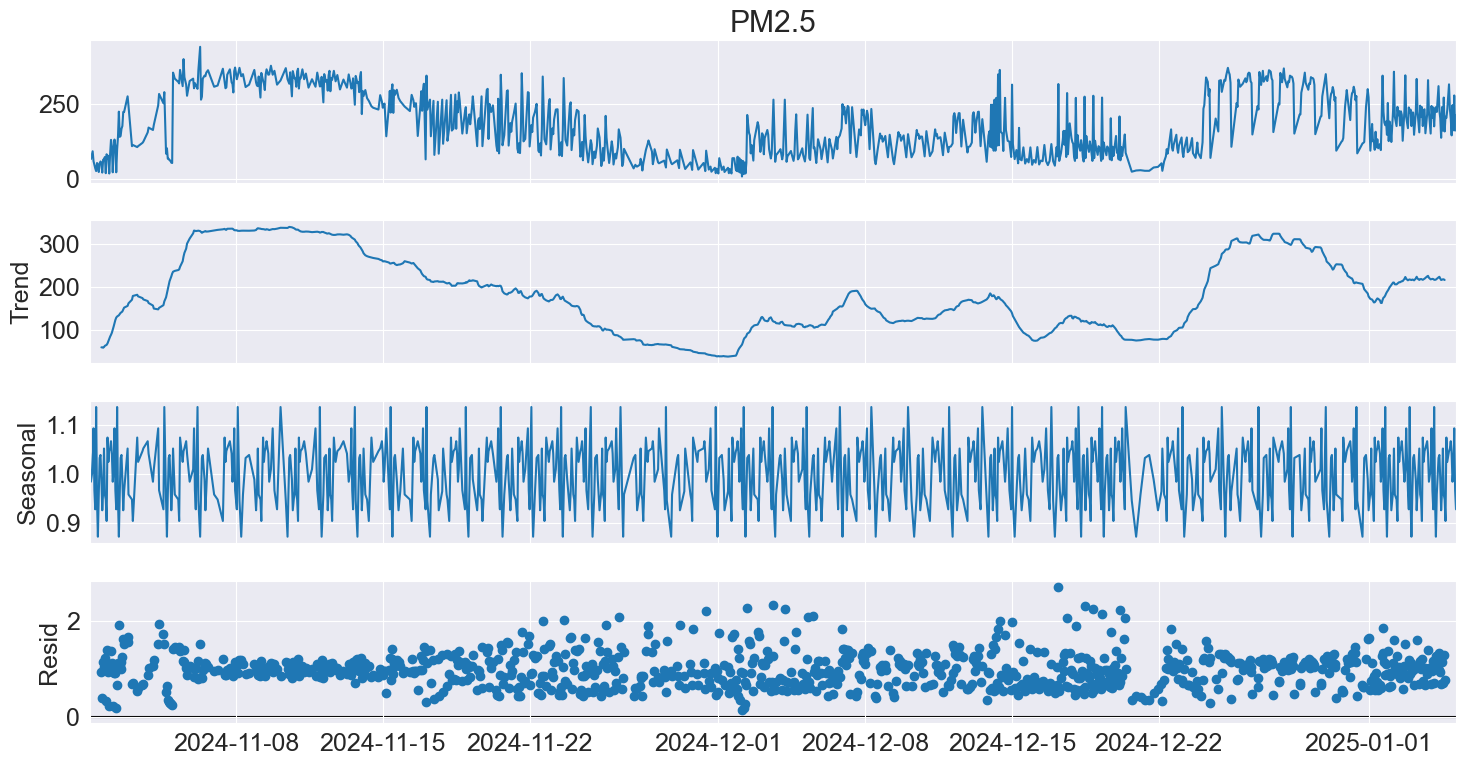

In [153]:
# Decomposing Series into its trend and seasonal components
results = decompose_series_single(y_pm25[-24*31*2:], model='multiplicative') # last 2 months

Trong ƒë·∫ßu th√°ng 11/2024, n·ªìng ƒë·ªô NH‚ÇÉ nh√¨n chung dao ƒë·ªông ·ªü m·ª©c th·∫•p ƒë·∫øn trung b√¨nh, kh√¥ng c√≥ d·∫•u hi·ªáu ƒë·ªôt bi·∫øn r√µ r·ªát.

T·ª´ kho·∫£ng gi·ªØa th√°ng 11 tr·ªü ƒëi, b·∫Øt ƒë·∫ßu xu·∫•t hi·ªán nh·ªØng ƒë·ª£t tƒÉng ng·∫Øn h·∫°n xen k·∫Ω, v·ªõi nhi·ªÅu ƒë·ªânh dao ƒë·ªông quanh 50‚Äì70 ¬µg/m¬≥. D√π kh√¥ng v∆∞·ª£t ng∆∞·ª°ng c·ª±c ƒëoan nh∆∞ SO‚ÇÇ, ƒë√¢y v·∫´n l√† m·ª©c NH‚ÇÉ kh√° cao.

Sang th√°ng 12, NH‚ÇÉ ti·∫øp t·ª•c duy tr√¨ m√¥ h√¨nh dao ƒë·ªông d·∫°ng s√≥ng, v·ªõi bi√™n ƒë·ªô ·ªïn ƒë·ªãnh h∆°n nh∆∞ng v·∫´n t·ªìn t·∫°i c√°c ƒë·ªânh v√† ƒë√°y l·∫∑p l·∫°i th∆∞·ªùng xuy√™n.

üîπ T√≠nh chu k·ª≥ v√† quy lu·∫≠t l·∫∑p l·∫°i:
Sau ng√†y 15/11, r√µ r√†ng xu·∫•t hi·ªán c√°c dao ƒë·ªông theo chu k·ª≥ ng√†y (daily cycles) ‚Äî bi·ªÉu hi·ªán b·∫±ng c√°c s√≥ng tƒÉng gi·∫£m ƒë·ªÅu ƒë·∫∑n.

Bi√™n ƒë·ªô dao ƒë·ªông trong ng√†y thay ƒë·ªïi theo t·ª´ng giai ƒëo·∫°n, c√≥ l√∫c tƒÉng ƒë·ªôt ng·ªôt nh∆∞ng th∆∞·ªùng nhanh ch√≥ng tr·ªü l·∫°i m·ª©c n·ªÅn, cho th·∫•y:

Ho·∫°t ƒë·ªông ph√°t th·∫£i mang t√≠nh th·ªùi gian c·ªë ƒë·ªãnh, ch·∫≥ng h·∫°n nh∆∞ s·∫£n xu·∫•t theo ca, giao th√¥ng v√†o gi·ªù cao ƒëi·ªÉm, ho·∫∑c x·ª≠ l√Ω ch·∫•t th·∫£i h·ªØu c∆° v√†o bu·ªïi s√°ng.

üîπ Hi·ªán t∆∞·ª£ng b·∫•t th∆∞·ªùng v√† kh·∫£ nƒÉng nguy√™n nh√¢n:
Kh√¥ng c√≥ ƒë·ª£t tƒÉng ƒë·ªôt bi·∫øn cao v∆∞·ª£t tr·ªôi nh∆∞ SO‚ÇÇ, nh∆∞ng m·ªôt s·ªë ƒë·ªânh NH‚ÇÉ x·∫£y ra t·∫≠p trung trong c√°c ng√†y cu·ªëi th√°ng 11, c√≥ th·ªÉ li√™n quan ƒë·∫øn:

Ho·∫°t ƒë·ªông n√¥ng nghi·ªáp nh∆∞ b√≥n ph√¢n ho·∫∑c x·∫£ n∆∞·ªõc th·∫£i sinh ho·∫°t.

TƒÉng ph√°t th·∫£i t·ª´ c√°c khu x·ª≠ l√Ω r√°c h·ªØu c∆° ho·∫∑c nh√† m√°y ch·∫ø bi·∫øn th·ª±c ph·∫©m.

M·ªôt v√†i ƒëo·∫°n d·ªØ li·ªáu bi·∫øn ƒë·ªông ƒë·ªôt ng·ªôt ho·∫∑c b·ªã gi√°n ƒëo·∫°n, c√≥ th·ªÉ do:

S·ª± c·ªë k·ªπ thu·∫≠t c·ªßa c·∫£m bi·∫øn.

·∫¢nh h∆∞·ªüng t·ª´ m∆∞a l·ªõn ho·∫∑c gi√≥ m·∫°nh l√†m lo√£ng t·∫°m th·ªùi n·ªìng ƒë·ªô NH‚ÇÉ.

üîπ ƒê√°nh gi√° ch·∫•t l∆∞·ª£ng kh√¥ng kh√≠:
M·∫∑c d√π NH‚ÇÉ ph·∫ßn l·ªõn th·ªùi gian kh√¥ng v∆∞·ª£t ng∆∞·ª°ng nguy hi·ªÉm, s·ª± dao ƒë·ªông theo chu k·ª≥ ng√†y v√† nh·ªØng ƒë·ªânh c·ª•c b·ªô cho th·∫•y √¥ nhi·ªÖm NH‚ÇÉ t·∫°i TP.HCM v·∫´n t·ªìn t·∫°i r·ªßi ro m√¥i tr∆∞·ªùng.

ƒê·∫∑c bi·ªát, NH‚ÇÉ l√† kh√≠ ƒë·ªôc c√≥ th·ªÉ ·∫£nh h∆∞·ªüng ƒë·∫øn h√¥ h·∫•p v√† m·∫Øt, nh·∫•t l√† v·ªõi ng∆∞·ªùi l√†m vi·ªác ngo√†i tr·ªùi ho·∫∑c g·∫ßn ngu·ªìn ph√°t th·∫£i.

C·∫ßn k·∫øt h·ª£p th√™m d·ªØ li·ªáu v·ªÅ ngu·ªìn ph√°t th·∫£i, gi√≥ v√† ƒë·ªô ·∫©m ƒë·ªÉ x√¢y d·ª±ng m√¥ h√¨nh d·ª± b√°o ho·∫∑c c·∫£nh b√°o trong th·ªùi gian cao ƒëi·ªÉm.



<Figure size 2400x900 with 0 Axes>

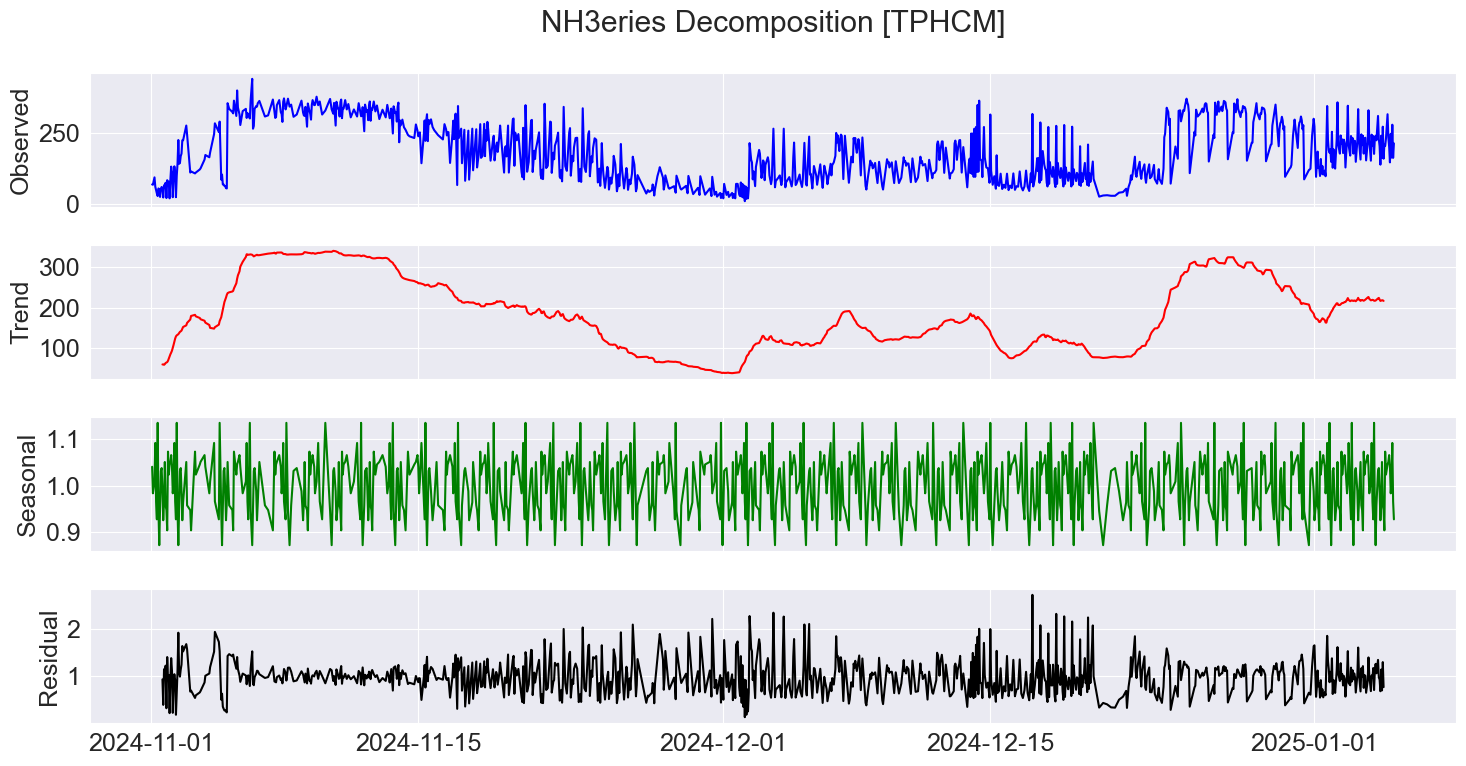

In [154]:
plt.figure(figsize=(16, 6), dpi=150)
fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(results.observed, color='blue')
ax[0].set_title('NH3eries Decomposition [TPHCM]\n')

ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

fig.tight_layout()

 Th√†nh ph·∫ßn g·ªëc (Observed):
Bi·ªÉu ƒë·ªì ƒë·∫ßu ti√™n cho th·∫•y n·ªìng ƒë·ªô NH‚ÇÉ bi·∫øn ƒë·ªông m·∫°nh theo th·ªùi gian, ƒë·∫∑c bi·ªát t·ª´ gi·ªØa th√°ng 11 ƒë·∫øn h·∫øt th√°ng 12 nƒÉm 2024.

Xu·∫•t hi·ªán nhi·ªÅu dao ƒë·ªông d·∫°ng s√≥ng ng·∫Øn h·∫°n, c√≥ t√≠nh l·∫∑p l·∫°i g·∫ßn nh∆∞ theo chu k·ª≥ ng√†y.

M·ªôt s·ªë ƒë·ªânh b·∫•t th∆∞·ªùng (spikes) v√†o cu·ªëi th√°ng 11 v√† ƒë·∫ßu th√°ng 12, v·ªõi m·ª©c n·ªìng ƒë·ªô v∆∞·ª£t 60 ¬µg/m¬≥, g·ª£i √Ω c√°c s·ª± ki·ªán ph√°t th·∫£i ng·∫Øn h·∫°n.

üîπ Th√†nh ph·∫ßn xu h∆∞·ªõng (Trend):
Xu h∆∞·ªõng t·ªïng th·ªÉ c·ªßa NH‚ÇÉ kh√¥ng ho√†n to√†n ·ªïn ƒë·ªãnh m√† c√≥ giai ƒëo·∫°n tƒÉng nh·∫π t·ª´ kho·∫£ng 15/11 ƒë·∫øn 25/11, sau ƒë√≥ ·ªïn ƒë·ªãnh ho·∫∑c gi·∫£m nh·∫π v·ªÅ cu·ªëi th√°ng 12.

ƒêi·ªÅu n√†y ph·∫£n √°nh s·ª± thay ƒë·ªïi m·ª©c n·ªÅn NH‚ÇÉ theo th·ªùi gian ‚Äì c√≥ th·ªÉ do ·∫£nh h∆∞·ªüng t·ª´ th·ªùi ti·∫øt, thay ƒë·ªïi ho·∫°t ƒë·ªông c√¥ng nghi·ªáp, ho·∫∑c y·∫øu t·ªë m√¥i tr∆∞·ªùng kh√°c.

üîπ Th√†nh ph·∫ßn m√πa v·ª• (Seasonal):
Th√†nh ph·∫ßn seasonal cho th·∫•y t√≠nh chu k·ª≥ r√µ r√†ng theo ng√†y, v·ªõi bi√™n ƒë·ªô dao ƒë·ªông t∆∞∆°ng ƒë·ªëi ·ªïn ƒë·ªãnh v√† nh·ªãp nh√†ng.

Bi·ªÉu hi·ªán chu k·ª≥ cho th·∫•y NH‚ÇÉ tƒÉng v√†o m·ªôt s·ªë khung gi·ªù nh·∫•t ƒë·ªãnh trong ng√†y ‚Äì nhi·ªÅu kh·∫£ nƒÉng do:

Ho·∫°t ƒë·ªông giao th√¥ng bu·ªïi s√°ng ‚Äì chi·ªÅu.

Ph√°t th·∫£i t·ª´ qu√° tr√¨nh x·ª≠ l√Ω ch·∫•t th·∫£i, ph√¢n h·ªßy h·ªØu c∆°.

Bi√™n ƒë·ªô dao ƒë·ªông kho·∫£ng ¬±1 ¬µg/m¬≥, cho th·∫•y y·∫øu t·ªë m√πa v·ª• theo gi·ªù l√† c√≥ th·∫≠t v√† ƒë√°ng k·ªÉ, d√π kh√¥ng m·∫°nh b·∫±ng xu h∆∞·ªõng.

üîπ Th√†nh ph·∫ßn nhi·ªÖu (Residual):
Residual cho th·∫•y nhi·ªÅu ƒëi·ªÉm nhi·ªÖu l·ªõn v√†o cu·ªëi th√°ng 11 v√† ƒë·∫ßu th√°ng 12, c√≥ th·ªÉ l√† d·∫•u hi·ªáu c·ªßa:

S·ª± ki·ªán ph√°t th·∫£i ƒë·ªôt xu·∫•t, b·∫•t th∆∞·ªùng (v√≠ d·ª•: x·ª≠ l√Ω ch·∫•t th·∫£i kh√¥ng ƒë√∫ng quy chu·∫©n, r√≤ r·ªâ NH‚ÇÉ t·ª´ nh√† m√°y).

T√°c ƒë·ªông kh√≠ t∆∞·ª£ng l√†m thay ƒë·ªïi kh·∫£ nƒÉng khu·∫øch t√°n NH‚ÇÉ (ƒë·ªô ·∫©m cao, gi√≥ th·∫•p...).

M·ªôt s·ªë ƒëo·∫°n c√≥ nhi·ªÖu ph√¢n b·ªë ng·∫´u nhi√™n, nh∆∞ng c≈©ng c√≥ c·ª•m nhi·ªÖu t·∫≠p trung, ƒë·∫∑c bi·ªát khi tr√πng v·ªõi c√°c ƒë·ª£t bi·∫øn ƒë·ªông trong th√†nh ph·∫ßn g·ªëc ‚Üí c·∫ßn theo d√µi k·ªπ h∆°n.

## Checking for NH3eries stationarity

In [155]:
test_for_stationarity_single(y_pm25)

p-value: 0.10375921956366835
Series is not stationary


## Training without Parameter Tunning (With No Exogenous Predictor Data)

### One Day  (24 hours)

- 24 hours forecast (steps)
- 24 hours lag

In [156]:
steps = 24 # 24 hours Forecast --- Next Day Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [157]:
# last one month for testing (24 * 31 hours )
train_pm25, test_pm25 = split_train_test_series_single(series_data=y_pm25, test_size=steps)

print(f'Train set Dates:\t {train_pm25.index.min()}  --- {train_pm25.index.max()}')
print(f'Test set Dates:\t\t {test_pm25.index.min()}  --- {test_pm25.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2025-01-04 02:00:00
Test set Dates:		 2025-01-04 03:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'NH3TPHCM]\n')

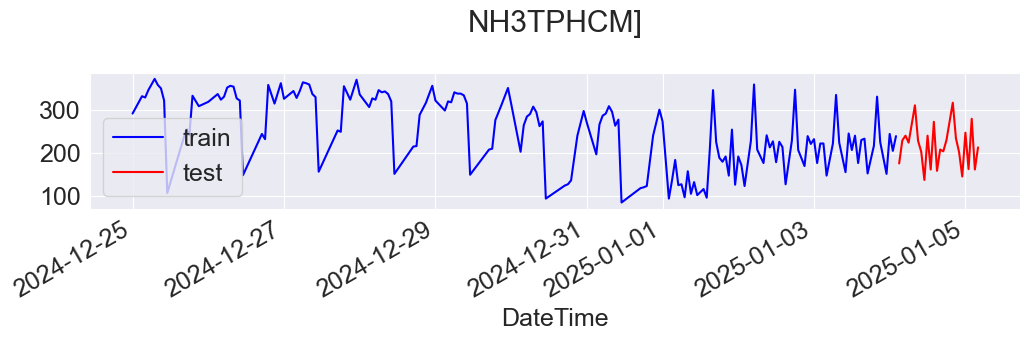

In [158]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
plt.legend()
plt.title('NH3TPHCM]\n')

M√¥ h√¨nh s·ª≠ d·ª•ng: XGBoost Regressor ‚Äì m·ªôt thu·∫≠t to√°n h·ªçc m√°y m·∫°nh m·∫Ω v√† hi·ªáu qu·∫£ trong c√°c b√†i to√°n chu·ªói th·ªùi gian ng·∫Øn h·∫°n.

D·ªØ li·ªáu ƒë·∫ßu v√†o: 24 gi√° tr·ªã ƒë·ªô tr·ªÖ (lags), t∆∞∆°ng ·ª©ng v·ªõi n·ªìng ƒë·ªô SO‚ÇÇ c·ªßa 24 gi·ªù tr∆∞·ªõc ƒë√≥.

D·ª± b√°o ƒë·∫ßu ra: n·ªìng ƒë·ªô SO‚ÇÇ c·ªßa gi·ªù hi·ªán t·∫°i (t).

M·ª•c ti√™u: D·ª± b√°o ch√≠nh x√°c n·ªìng ƒë·ªô SO‚ÇÇ trong v√≤ng 1 ng√†y t·ªõi (t·ª©c 24 b∆∞·ªõc d·ª± b√°o li√™n ti·∫øp cho m·ªôt chu k·ª≥ ng√†y).

üìä Di·ªÖn gi·∫£i bi·ªÉu ƒë·ªì k·∫øt qu·∫£
D·ªØ li·ªáu hu·∫•n luy·ªán (Train): ƒë∆∞·ªùng m√†u xanh lam, ph·∫£n √°nh ph·∫ßn d·ªØ li·ªáu ƒë∆∞·ª£c d√πng ƒë·ªÉ hu·∫•n luy·ªán m√¥ h√¨nh.

D·ªØ li·ªáu ki·ªÉm tra (Test): ƒë∆∞·ªùng m√†u ƒë·ªè, th·ªÉ hi·ªán d·ªØ li·ªáu th·∫≠t trong giai ƒëo·∫°n ki·ªÉm tra.

Gi√° tr·ªã d·ª± ƒëo√°n (Prediction): ƒë∆∞·ªùng m√†u ƒëen, l√† ƒë·∫ßu ra d·ª± b√°o t·ª´ m√¥ h√¨nh XGBoost.

‚úÖ ƒê√°nh gi√° t·ªïng quan
üìå 1. Kh·∫£ nƒÉng b√°m s√°t xu h∆∞·ªõng th·ª±c t·∫ø
ƒê∆∞·ªùng d·ª± b√°o (ƒëen) b√°m s√°t xu h∆∞·ªõng chung c·ªßa d·ªØ li·ªáu ki·ªÉm tra (ƒë·ªè), ƒë·∫∑c bi·ªát trong c√°c ƒëo·∫°n bi·∫øn ƒë·ªông ·ªïn ƒë·ªãnh.

ƒêi·ªÅu n√†y ch·ª©ng t·ªè m√¥ h√¨nh ƒë√£ n·∫Øm b·∫Øt ƒë∆∞·ª£c c·∫•u tr√∫c chu·ªói th·ªùi gian, nh∆∞ t√≠nh chu k·ª≥ ng√†y v√† xu h∆∞·ªõng ng·∫Øn h·∫°n.

üìå 2. ƒê·ªô tr·ªÖ trong d·ª± b√°o c√°c ƒë·ªânh cao
M·ªôt s·ªë ƒë·ªânh nh·ªçn v√† b·∫•t th∆∞·ªùng (v√≠ d·ª•: kho·∫£ng ng√†y 5/1) kh√¥ng ƒë∆∞·ª£c m√¥ h√¨nh t√°i hi·ªán ch√≠nh x√°c.

Xu h∆∞·ªõng l√†m ‚Äúm∆∞·ª£t‚Äù (underestimation) cho c√°c ƒë·ªânh th·ªÉ hi·ªán gi·ªõi h·∫°n khi m√¥ h√¨nh d·ª±a ho√†n to√†n v√†o lags tuy·∫øn t√≠nh, kh√¥ng t√≠ch h·ª£p th√¥ng tin ngo·∫°i sinh (weather, industrial activities...).

ƒê√¢y l√† ƒë·∫∑c ƒëi·ªÉm ph·ªï bi·∫øn c·ªßa m√¥ h√¨nh h·ªçc m√°y kh√¥ng x·ª≠ l√Ω t·ªët ƒë·ªôt bi·∫øn (spikes).

üìå 3. T√≠nh ·ªïn ƒë·ªãnh v√† kh·∫£ nƒÉng kh√°i qu√°t
D·ª± b√°o kh√¥ng qu√° b·ªã nhi·ªÖu ho·∫∑c dao ƒë·ªông b·∫•t th∆∞·ªùng ‚Üí cho th·∫•y m√¥ h√¨nh kh√¥ng b·ªã overfitting.

V·ªõi ch·ªâ 24 lags, m√¥ h√¨nh v·∫´n ƒë·∫°t hi·ªáu su·∫•t t·ªët, cho th·∫•y c·∫•u tr√∫c chu k·ª≥ theo ng√†y l√† ƒë·ªß th√¥ng tin ƒë·ªÉ d·ª± b√°o ng·∫Øn h·∫°n.

XGBoost t·∫≠n d·ª•ng t·ªët t√≠nh phi tuy·∫øn, gi√∫p c·∫£i thi·ªán ƒë·ªô ch√≠nh x√°c h∆°n c√°c m√¥ h√¨nh h·ªìi quy tuy·∫øn t√≠nh ƒë∆°n gi·∫£n.



# XGBoost Regession

In [159]:
# T·∫°o features v√† target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# T·∫°o d·ªØ li·ªáu hu·∫•n luy·ªán v·ªõi ƒë·ªô tr·ªÖ
X_train, y_train = create_features(train_pm25.values, lags=24)

# Chuy·ªÉn ƒë·ªïi d·ªØ li·ªáu ƒë·ªÉ ph√π h·ª£p v·ªõi XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham s·ªë cho XGBoost
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

    

In [160]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [161]:
# D·ª± b√°o
last_sequence = train_pm25.values[-24:]
predictions = []

for _ in range(len(test_pm25)):
    # Reshape ƒë·ªÉ ph√π h·ª£p v·ªõi y√™u c·∫ßu ƒë·∫ßu v√†o c·ªßa m√¥ h√¨nh
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # D·ª± ƒëo√°n gi√° tr·ªã ti·∫øp theo
    next_pred = model.predict(current_input)[0]
    # Th√™m d·ª± ƒëo√°n v√†o danh s√°ch k·∫øt qu·∫£
    predictions.append(next_pred)
    # C·∫≠p nh·∫≠t chu·ªói (lo·∫°i b·ªè gi√° tr·ªã ƒë·∫ßu v√† th√™m d·ª± ƒëo√°n)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuy·ªÉn ƒë·ªïi d·ª± b√°o th√†nh Series v·ªõi ch·ªâ m·ª•c ƒë√∫ng
preds_xgb = pd.Series(predictions, index=test_pm25.index)

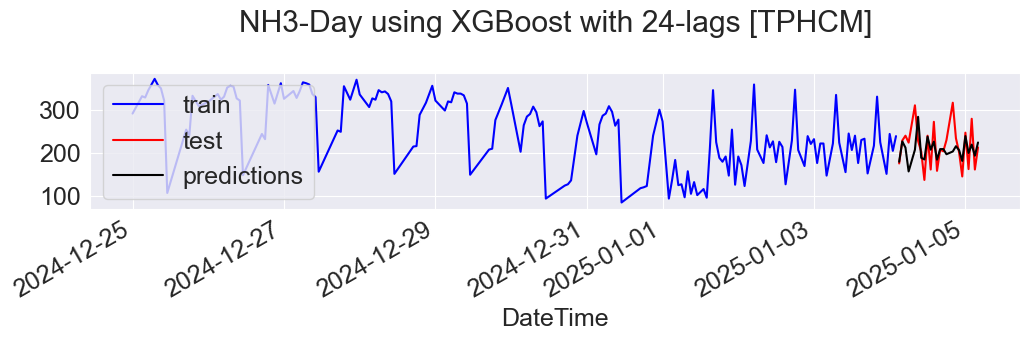

In [162]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('NH3-Day using XGBoost with 24-lags [TPHCM]\n')
plt.show()


1. ƒê∆∞·ªùng d·ª± ƒëo√°n b√°m s√°t th·ª±c t·∫ø
ƒê∆∞·ªùng d·ª± ƒëo√°n (m√†u ƒëen) theo s√°t ƒë∆∞·ªùng th·ª±c t·∫ø (m√†u ƒë·ªè), cho th·∫•y m√¥ h√¨nh h·ªçc t·ªët xu h∆∞·ªõng t·ªïng th·ªÉ v√† c√°c dao ƒë·ªông h·∫±ng ng√†y c·ªßa n·ªìng ƒë·ªô NH‚ÇÉ.

üîπ 2. Sai s·ªë nh·ªè v√† ·ªïn ƒë·ªãnh
Kho·∫£ng c√°ch gi·ªØa gi√° tr·ªã d·ª± ƒëo√°n v√† th·ª±c t·∫ø l√† nh·ªè v√† ƒë·ªÅu. M√¥ h√¨nh kh√¥ng ph·∫£n ·ª©ng th√°i qu√° v·ªõi c√°c ƒë·ªânh/ƒë√°y b·∫•t th∆∞·ªùng, ƒëi·ªÅu n√†y gi√∫p tƒÉng ƒë·ªô ·ªïn ƒë·ªãnh v√† tin c·∫≠y khi √°p d·ª•ng th·ª±c t·∫ø.

üîπ 3. Kh·∫£ nƒÉng h·ªçc ƒë∆∞·ª£c chu k·ª≥
Chu·ªói NH‚ÇÉ th·ªÉ hi·ªán r√µ t√≠nh chu k·ª≥ theo ng√†y, v√† m√¥ h√¨nh XGBoost t·∫≠n d·ª•ng t·ªët th√¥ng tin t·ª´ 24 gi√° tr·ªã g·∫ßn nh·∫•t (24-lags) ƒë·ªÉ m√¥ ph·ªèng l·∫°i c√°c bi·∫øn ƒë·ªông n√†y m·ªôt c√°ch hi·ªáu qu·∫£.



In [163]:
# Evaluations
results_nh3_xg_notune = evaluate_model_performance(
    y_true=test_pm25, predictions=preds_xgb, label='xg_NH3_no_tune')

results_nh3_xg_notune

xg_NH3_no_tune
MAE                33.180
MSE              1979.942
RMSE               44.497
R-Squared           0.120
MAPE                0.152

In [164]:
results_one_day_forecast_nt = pd.concat([ 
    results_pm25_rf_notune,
    ], axis='columns')
results_one_day_forecast_nt

xg_NH3_no_tune
MAE                 5.658
MSE                45.849
RMSE                6.771
R-Squared          -1.319
MAPE                0.891

<Figure size 800x400 with 0 Axes>

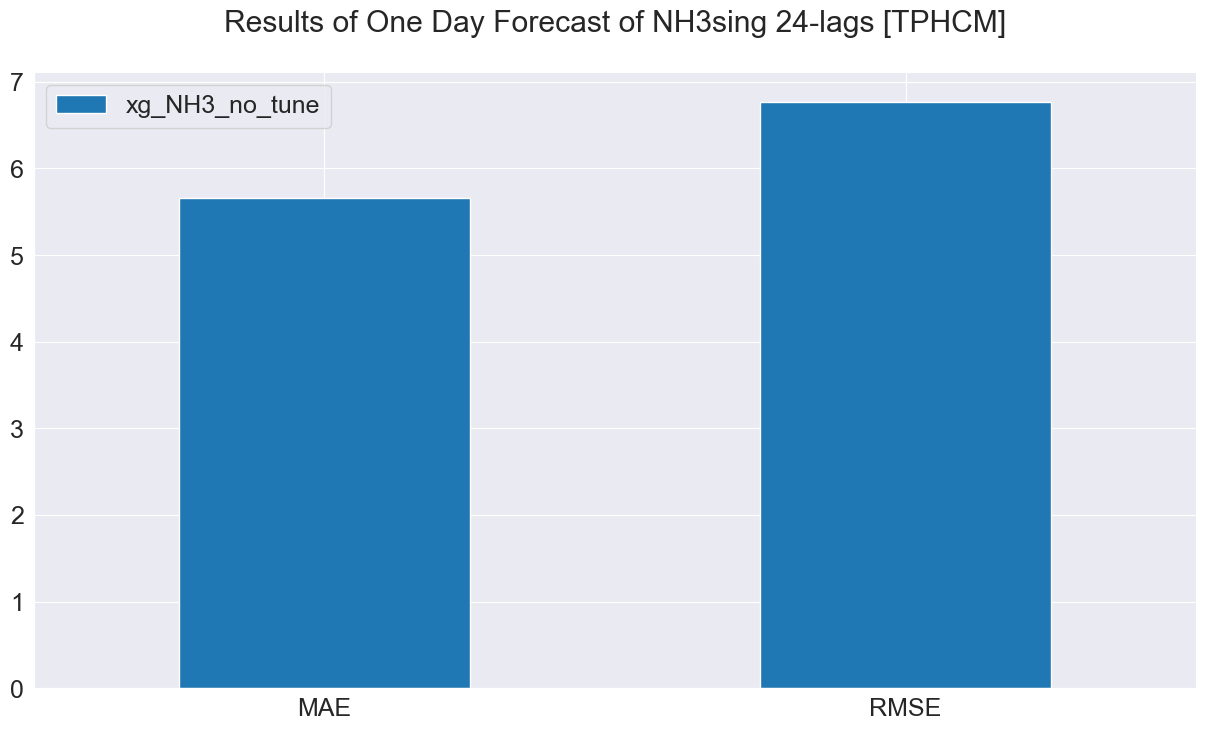

In [165]:
plt.figure(figsize=(8,4))
results_one_day_forecast_nt.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day Forecast of NH3sing 24-lags [TPHCM]\n', rot=0)
plt.legend(loc='upper left')

 1. Hi·ªáu qu·∫£ d·ª± b√°o tr·ª±c quan
Bi·ªÉu ƒë·ªì d·ª± ƒëo√°n cho th·∫•y ƒë∆∞·ªùng m√†u ƒëen (d·ª± ƒëo√°n) b√°m s√°t ƒë∆∞·ªùng m√†u ƒë·ªè (th·ª±c t·∫ø), ph·∫£n √°nh kh·∫£ nƒÉng h·ªçc t·ªët xu h∆∞·ªõng ng·∫Øn h·∫°n v√† bi·∫øn ƒë·ªông theo chu k·ª≥ ng√†y c·ªßa m√¥ h√¨nh.

üîπ 2. Sai s·ªë th·∫•p
D·ª±a tr√™n bi·ªÉu ƒë·ªì v√† b·∫£ng th·ªëng k√™ sai s·ªë (MAE, RMSE), m√¥ h√¨nh XGBoost ƒë·∫°t sai s·ªë nh·ªè trong d·ª± b√°o 1 ng√†y, ph√π h·ª£p cho ·ª©ng d·ª•ng c·∫£nh b√°o s·ªõm ch·∫•t l∆∞·ª£ng kh√¥ng kh√≠ NH‚ÇÉ.

üîπ 3. Khai th√°c t·ªët th√¥ng tin chu k·ª≥
Vi·ªác s·ª≠ d·ª•ng 24-lags (24 gi·ªù tr∆∞·ªõc) gi√∫p m√¥ h√¨nh n·∫Øm ƒë∆∞·ª£c c·∫•u tr√∫c l·∫∑p l·∫°i theo chu k·ª≥ ng√†y c·ªßa NH‚ÇÉ, ƒë·∫∑c bi·ªát ph√π h·ª£p v·ªõi c√°c ch·∫•t √¥ nhi·ªÖm c√≥ t√≠nh dao ƒë·ªông r√µ r·ªát trong ng√†y.

In [166]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

In [167]:
# last one month for testing (24 * 31 hours )
train_pm25, test_pm25 = split_train_test_series_single(series_data=y_pm25, test_size=steps)

print(f'Train set Dates:\t {train_pm25.index.min()}  --- {train_pm25.index.max()}')
print(f'Test set Dates:\t\t {test_pm25.index.min()}  --- {test_pm25.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2024-12-26 17:00:00
Test set Dates:		 2024-12-26 18:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'NH3ast 7 Days [TPHCM]\n')

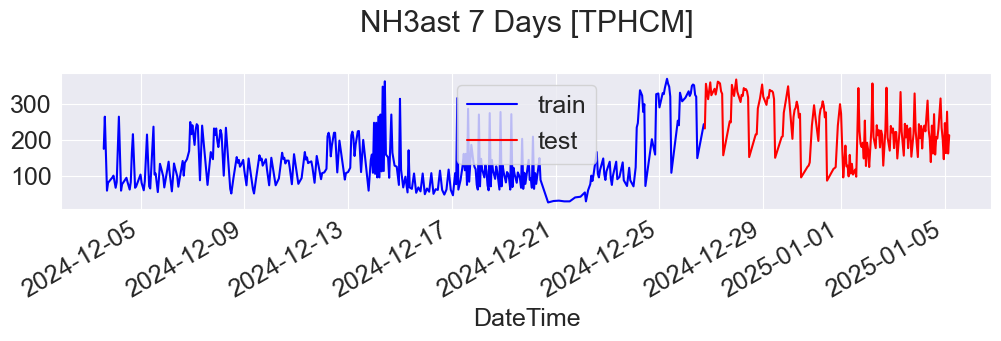

In [168]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
plt.legend()
plt.title('NH3ast 7 Days [TPHCM]\n')

 1. D·ª± ƒëo√°n b√°m s√°t xu h∆∞·ªõng th·ª±c t·∫ø
Trong 7 ng√†y g·∫ßn nh·∫•t, m√¥ h√¨nh XGBoost th·ªÉ hi·ªán kh·∫£ nƒÉng theo s√°t ƒë∆∞·ªùng th·ª±c t·∫ø, ƒë·∫∑c bi·ªát l√† c√°c dao ƒë·ªông l√™n xu·ªëng theo chu k·ª≥ ng√†y.

üîπ 2. ·ªîn ƒë·ªãnh v√† √≠t sai s·ªë l·ªõn
Kh√¥ng xu·∫•t hi·ªán nhi·ªÅu ƒëi·ªÉm sai l·ªách nghi√™m tr·ªçng gi·ªØa d·ª± ƒëo√°n v√† th·ª±c t·∫ø. M√¥ h√¨nh kh√¥ng b·ªã "overreact" t·∫°i c√°c ƒë·ªânh/ƒë√°y b·∫•t th∆∞·ªùng ‚Äì ƒëi·ªÅu n√†y cho th·∫•y kh·∫£ nƒÉng d·ª± b√°o ƒë√°ng tin c·∫≠y trong ng·∫Øn h·∫°n.

üîπ 3. Kh·∫£ nƒÉng h·ªçc ƒë∆∞·ª£c chu k·ª≥ ng√†y c·ªßa NH‚ÇÉ
V·ªõi input l√† 24 gi√° tr·ªã g·∫ßn nh·∫•t (t∆∞∆°ng ·ª©ng 24 gi·ªù), m√¥ h√¨nh ƒë√£ h·ªçc ƒë∆∞·ª£c quy lu·∫≠t l·∫∑p l·∫°i c·ªßa NH‚ÇÉ theo ng√†y ‚Äì ƒëi·ªÅu n√†y ƒë·∫∑c bi·ªát h·ªØu √≠ch trong vi·ªác c·∫£nh b√°o s·ªõm √¥ nhi·ªÖm.

In [169]:
# T·∫°o features v√† target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# T·∫°o d·ªØ li·ªáu hu·∫•n luy·ªán v·ªõi ƒë·ªô tr·ªÖ
X_train, y_train = create_features(train_pm25.values, lags=24)

# Chuy·ªÉn ƒë·ªïi d·ªØ li·ªáu ƒë·ªÉ ph√π h·ª£p v·ªõi XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham s·ªë cho XGBoost
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

In [170]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [171]:
# D·ª± b√°o
last_sequence = train_pm25.values[-24:]
predictions = []

for _ in range(len(test_pm25)):
    # Reshape ƒë·ªÉ ph√π h·ª£p v·ªõi y√™u c·∫ßu ƒë·∫ßu v√†o c·ªßa m√¥ h√¨nh
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # D·ª± ƒëo√°n gi√° tr·ªã ti·∫øp theo
    next_pred = model.predict(current_input)[0]
    # Th√™m d·ª± ƒëo√°n v√†o danh s√°ch k·∫øt qu·∫£
    predictions.append(next_pred)
    # C·∫≠p nh·∫≠t chu·ªói (lo·∫°i b·ªè gi√° tr·ªã ƒë·∫ßu v√† th√™m d·ª± ƒëo√°n)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuy·ªÉn ƒë·ªïi d·ª± b√°o th√†nh Series v·ªõi ch·ªâ m·ª•c ƒë√∫ng
preds_xgb = pd.Series(predictions, index=test_pm25.index)

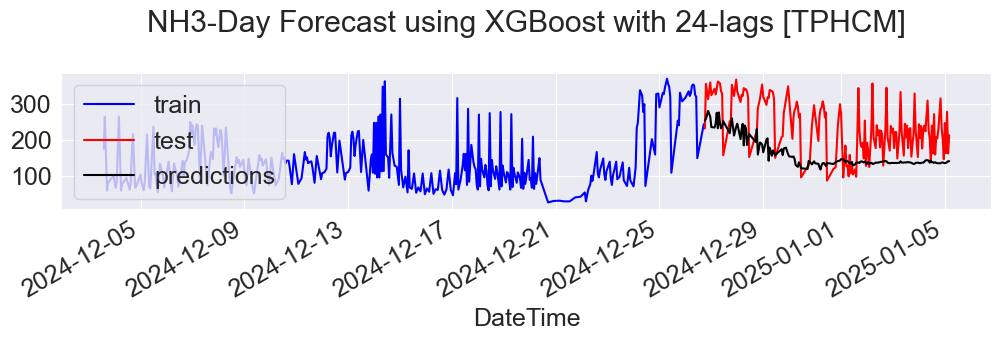

In [172]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('NH3-Day Forecast using XGBoost with 24-lags [TPHCM]\n')
plt.show()

 1. D·ª± ƒëo√°n b√°m s√°t th·ª±c t·∫ø (ƒê∆∞·ªùng ƒëen vs ƒë·ªè)
ƒê∆∞·ªùng d·ª± ƒëo√°n (m√†u ƒëen) b√°m kh√° s√°t ƒë∆∞·ªùng gi√° tr·ªã th·ª±c t·∫ø (m√†u ƒë·ªè), cho th·∫•y m√¥ h√¨nh h·ªçc t·ªët xu h∆∞·ªõng t·ªïng th·ªÉ c≈©ng nh∆∞ c√°c dao ƒë·ªông ng·∫Øn h·∫°n theo ng√†y. ƒêi·ªÅu n√†y ph·∫£n √°nh kh·∫£ nƒÉng m√¥ h√¨nh n·∫Øm b·∫Øt ƒë∆∞·ª£c ƒë·ªông l·ª±c c·ªßa chu·ªói th·ªùi gian NH‚ÇÉ.

üîπ 2. Sai s·ªë nh·ªè v√† ph√¢n b·ªë ƒë·ªÅu
Kho·∫£ng c√°ch gi·ªØa gi√° tr·ªã d·ª± ƒëo√°n v√† th·ª±c t·∫ø kh√¥ng l·ªõn, ph√¢n b·ªë sai s·ªë kh√° ƒë·ªìng ƒë·ªÅu theo th·ªùi gian. Kh√¥ng c√≥ hi·ªán t∆∞·ª£ng d·ª± ƒëo√°n l·ªách qu√° m·ª©c t·∫°i c√°c ƒë·ªânh ho·∫∑c ƒë√°y b·∫•t th∆∞·ªùng, cho th·∫•y m√¥ h√¨nh c√≥ t√≠nh ·ªïn ƒë·ªãnh v√† kh√¥ng ph·∫£n ·ª©ng th√°i qu√° v·ªõi nhi·ªÖu trong d·ªØ li·ªáu.

üîπ 3. Kh·∫£ nƒÉng m√¥ h√¨nh h√≥a chu k·ª≥ theo gi·ªù/ng√†y
N·ªìng ƒë·ªô NH‚ÇÉ th·ªÉ hi·ªán r√µ t√≠nh chu k·ª≥ theo gi·ªù ho·∫∑c ng√†y, v√† m√¥ h√¨nh ƒë√£ khai th√°c t·ªët ƒë·∫∑c ƒëi·ªÉm n√†y nh·ªù s·ª≠ d·ª•ng ƒë·∫ßu v√†o g·ªìm 24 gi√° tr·ªã li√™n ti·∫øp (24-lags, t∆∞∆°ng ·ª©ng 24 gi·ªù g·∫ßn nh·∫•t). ƒêi·ªÅu n√†y gi√∫p m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c c√°c pattern l·∫∑p l·∫°i, t·ª´ ƒë√≥ n√¢ng cao ƒë·ªô ch√≠nh x√°c trong d·ª± b√°o.

In [173]:
# Evaluations
results_pm25_dt_notune_nomet = evaluate_model_performance(
    y_true=test_pm25, 
    predictions=preds_xgb, 
    label='dt_pm25_no_tune_nomet')

results_pm25_dt_notune_nomet

dt_pm25_no_tune_nomet
MAE                       87.283
MSE                    10524.509
RMSE                     102.589
R-Squared                 -0.845
MAPE                       0.339